Compare equilibrium results with the stationary state of the dynamics

In [25]:
using MatrixProductBP, MatrixProductBP.Models
using Statistics, Base.Threads, Plots, Graphs, IndexedGraphs, Random
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using LaTeXStrings
import Measurements: value
import IsingChains;

In [91]:
T = 20
N = 10
gg = path_graph(N)
J = -rand(ne(gg))
h = randn(nv(gg))
β = 1.0
ising = Ising(IndexedGraph(gg); J, h, β)
chain = IsingChains.IsingChain(J, h, β)

m⁰ = 0.5
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp(Glauber(ising, T); ϕ=fill(ϕᵢ, N))
cb = CB_BP(bp);

In [92]:
svd_trunc = TruncBondThresh(5,1e-4)
iters, cb = iterate!(bp, maxiter=20; svd_trunc, cb, tol=1e-3, damp=0.5);

Running MPBP: iter 6 	 Time: 0:00:19
  Δ:                  0.0007538903744555014
  SVD tolerance, m':  0.0001, 5

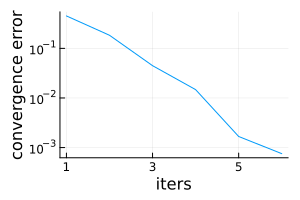

In [93]:
plot(cb.Δs, ylabel="convergence error", xlabel="iters", yaxis=:log10, 
    size=(300,200), label="", xticks=1:(length(cb.Δs)÷3):length(cb.Δs))

In [94]:
spin(x, i) = 3-2x
spin(x) = spin(x, 0)
m_bp = means(spin, bp)
m = mean(m_bp);

In [98]:
pb_, = pair_beliefs_as_mpem(bp)
pb = [pb_[ij] for (i,j,ij) in edges(bp.g) if i < j]
r_bp = map(pb) do pbij
    mtu = marginals_tu(pbij)
    [expectation(spin, dropdims(sum(sum(mtu[t,t+1], dims=2), dims=3); dims=(2,3))) 
        for t in 1:T]
end
r = mean(r_bp);

In [96]:
m_eq = mean(IsingChains.site_magnetizations(chain))
r_eq = mean(IsingChains.neighbor_magnetizations(chain));

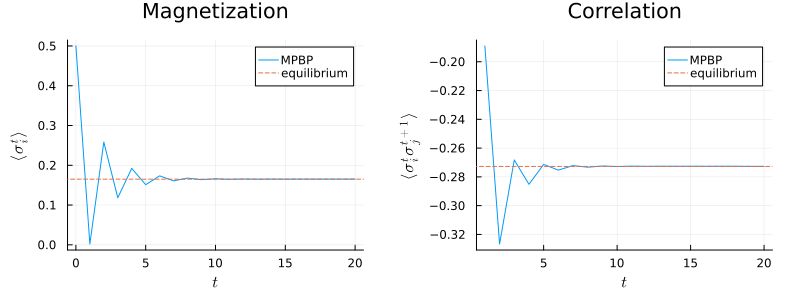

In [97]:
pl_m = plot(0:T, m, xlabel=L"t", ylabel=L"\langle \sigma_i^t \rangle", msc=:auto,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP")
hline!(pl_m, [m_eq], label="equilibrium", ls=:dash, title="Magnetization")

pl_r = plot(1:T, r, xlabel=L"t", ylabel=L"\langle \sigma_i^t\sigma_j^{t+1} \rangle", msc=:auto,
    size=(500,300), xticks=0:5:T, ms=2, label="MPBP")
hline!(pl_r, [r_eq], label="equilibrium", ls=:dash, title="Correlation")

plot(pl_m, pl_r, size=(800,300), margin=5Plots.mm)